In [1]:
# import libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import medmnist
from medmnist import INFO, Evaluator
import numpy as np
from tqdm import tqdm

# specify the data to grab -- 'pathmnist' for pathology images
data_flag = 'pathmnist'
download = True

# get dataset information
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# transform each image to PIL or NumPy arrays & scale them
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the datasets
DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# create data loaders
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# define the CNN
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# set device (to GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model, loss function, and optimizer
model = CNN(in_channels=n_channels, num_classes=n_classes).to(device)

if task == 'multi-label, binary-class':
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        if task == 'multi-label, binary-class':
            targets = targets.float()
        else:
            targets = targets.squeeze().long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

# evaluation on the test set
model.eval()
y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = outputs.cpu()
        y_score.append(outputs)
        y_true.append(targets)

y_score = torch.cat(y_score)
y_true = torch.cat(y_true)

# apply softmax for multi-class classification
if task == 'multi-label, binary-class':
    y_pred = y_score.numpy()  # retain logits for multi-label binary task
    y_true = y_true.numpy()
    y_pred = 1 / (1 + np.exp(-y_pred))  # sigmoid activation
else:
    y_pred = torch.softmax(y_score, dim=1).numpy()  # softmax for multi-class to get probabilities
    y_true = y_true.squeeze().numpy()

# initialize the evaluator and evaluate
evaluator = Evaluator(data_flag, 'test')
if task == 'multi-label, binary-class':
    auc = evaluator.evaluate(y_pred)
    print('Test AUC:', auc)
else:
    acc = evaluator.evaluate(y_pred)
    print('Test Accuracy:', acc)

Using downloaded and verified file: /Users/cyruskurd/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/cyruskurd/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/cyruskurd/.medmnist/pathmnist.npz


100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.38it/s]


Epoch [1/5], Training Loss: 0.6401


100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 33.72it/s]


Epoch [2/5], Training Loss: 0.3886


100%|█████████████████████████████████████████| 704/704 [00:21<00:00, 32.38it/s]


Epoch [3/5], Training Loss: 0.3202


100%|█████████████████████████████████████████| 704/704 [00:21<00:00, 32.88it/s]


Epoch [4/5], Training Loss: 0.2768


100%|█████████████████████████████████████████| 704/704 [00:22<00:00, 31.93it/s]


Epoch [5/5], Training Loss: 0.2513


100%|███████████████████████████████████████████| 57/57 [00:00<00:00, 73.02it/s]

Test Accuracy: Metrics(AUC=0.9370670462879319, ACC=0.799025069637883)


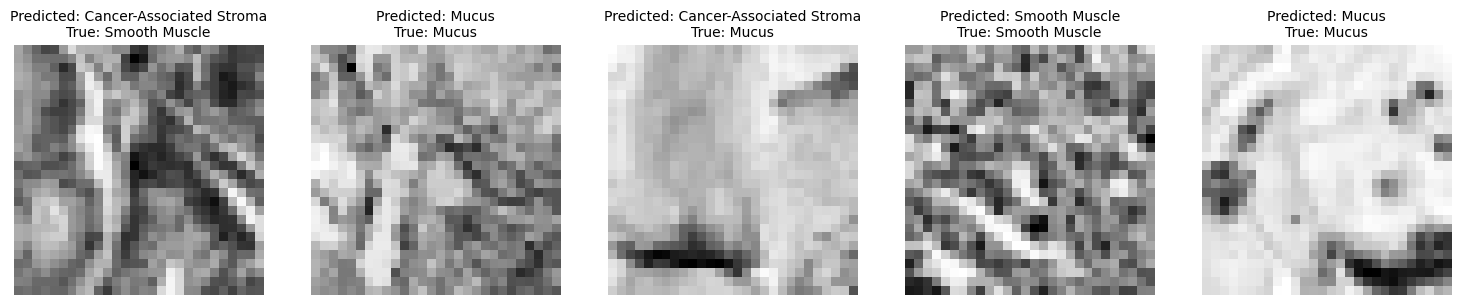

In [2]:
import matplotlib.pyplot as plt

# display a few images with their predictions and true labels
def display_predictions_with_images(model, data_loader, num_images=5):

    class_labels = [
    "Adipose Tissue", "Background", "Debris", "Lymphocytes",
    "Mucus", "Normal Colon Mucosa", "Cancer-Associated Stroma",
    "Colorectal Adenocarcinoma Epithelium", "Smooth Muscle"
    ]
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3), dpi=100)  # Adjusted figure size and DPI
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # get the predicted class index

            inputs = inputs.cpu()  # move images back to CPU for display
            predicted = predicted.cpu()
            targets = targets.squeeze().cpu()

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break
                ax = axes[images_shown]
                # select the first channel for grayscale display with improved visibility
                ax.imshow(inputs[i][0], cmap='gray', interpolation='none')  # Set interpolation to 'none'
                ax.axis('off')
                ax.set_aspect('equal')  # Ensure aspect ratio is equal
                # display readable class names for predicted and true labels
                pred_label = class_labels[predicted[i].item()]
                true_label = class_labels[targets[i].item()]
                ax.set_title(f"Predicted: {pred_label}\nTrue: {true_label}", fontsize=10)
                images_shown += 1
            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

# display a few images with their predictions and true labels
display_predictions_with_images(model, test_loader, num_images=5)